In [3]:
# 1 imports
import pandas as pd
from matplotlib import pyplot as plt
import os
import numpy as np
import random
import io
from IPython.display import clear_output
import time
import matplotlib.animation
import math
import pickle

In [4]:
# 2 runfile directories
runfile_directory = 'Runfiles/'
results_directory = 'Results/'
template_file = 'template.txt'

In [5]:
# 3 parameter dict and template writing functions
parameter_dict = {'*fname': ['Python/Results/'],
                  '*steps': ['200'],
                 '*reps': ['50'],
                 'letter_grades' : ['true'],
                  'prefix' : ["adjusted_sweeps"],
                  'grading_error_alpha' : ['150.0'],
                  'grading_error_beta' : ['150.0'],
                  'divorce_constant' : ['100',  '50', '25', '10', '0'],
                  'max_strikes' : ['3', '5', '7', '11', '13'],
                  'num_agents' : ['60'],
                  'agent_tolerance_alpha' : ['1.0' , '2.0'], # (1,1), else alpha < beta for tolerance, with a hard cap of 4 grades down, old: '1.', '2.', '3.0', '4.0', '5.0'
                  'agent_tolerance_beta' : ['1.0', '7.0'], #old '1.', '3.', '5.', '7.0', '8.0', '10.0'
                  'agent_effort_alpha' : ['5.0', '10.0'],
                  'agent_effort_beta' : ['1.5', '3.0', '5.0'], # effort beta < effort alpha
                  'agent_std_effort' : ['0.01', '0.05', '0.075', '0.1', '0.2'],
                  'min_agents_per_group' : ['3'],
                  'max_agents_per_group' : ['4'],
                  'group_track_rate' : ['1'],
                  'agent_track_rate' : ['5'],
                  'group_write_directory' : ['Python/Group_data/'],
                  'agent_write_directory' : ['Python/Agent_data/'],
                 }

def design_runfile(new_fname, parameter_dict=parameter_dict):
    with open(template_file) as template:
        template_lines = template.readlines()

    parameter_dict['*fname'] = [parameter_dict['*fname'][0] + new_fname.strip('.txt')]
    
    with open(runfile_directory + new_fname, 'w+') as new_file:
        for line in template_lines:
            param = line.split()[0]
            if param not in parameter_dict:
                new_file.write(line)
            else:
                fixer_upper = line.strip('\n').split()[:2]
                new_line = ' '.join(fixer_upper + (parameter_dict[param])) + '\n'
                new_file.write(new_line)
                
def delete_old_files(agent_dir, group_dir):
    agent_files = os.listdir(agent_dir)
    group_files = os.listdir(group_dir)
    for file_name in agent_files:
        file_path = os.path.join(agent_dir, file_name)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)  # Remove the file or link
        except Exception as e:
            print(f'Failed to delete {file_path}. Reason: {e}')
    for file_name in group_files:
        file_path = os.path.join(group_dir, file_name)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)  # Remove the file or link
        except Exception as e:
            print(f'Failed to delete {file_path}. Reason: {e}')

In [4]:
# 4 Create the run file
# parameter_dict['letter_grades'] = ['true']
# parameter_dict['*fname'] = ['Python/Results/']
# parameter_dict['prefix'] = ['server_runs_true_60']
# parameter_dict['group_write_directory'] = ['Python/true_60/Group_data/']
# parameter_dict['agent_write_directory'] = ['Python/true_60/Agent_data/']
# design_runfile('server_runs_true_60.txt', parameter_dict)

# parameter_dict['num_agents'] = ['150']
# parameter_dict['prefix'] = ['server_runs_true_150']
# parameter_dict['group_write_directory'] = ['Python/true_150/Group_data/']
# parameter_dict['agent_write_directory'] = ['Python/true_150/Agent_data/']
# design_runfile('server_runs_true_150.txt', parameter_dict)

# parameter_dict['num_agents'] = ['200']
# parameter_dict['prefix'] = ['server_runs_true_200']
# parameter_dict['group_write_directory'] = ['Python/true_200/Group_data/']
# parameter_dict['agent_write_directory'] = ['Python/true_200/Agent_data/']
# design_runfile('server_runs_true_200.txt', parameter_dict)

# parameter_dict['letter_grades'] = ['false']
# parameter_dict['*fname'] = ['Python/test/']
# parameter_dict['prefix'] = ['server_runs_false_60']
# parameter_dict['group_write_directory'] = ['Python/false_60/Group_data/']
# parameter_dict['agent_write_directory'] = ['Python/false_60/Agent_data/']
# design_runfile('server_runs_false_60.txt', parameter_dict)

#parameter_dict['num_agents'] = ['150']
#parameter_dict['prefix'] = ['server_runs_false_150']
#parameter_dict['group_write_directory'] = ['Python/false_150/Group_data/']
#parameter_dict['agent_write_directory'] = ['Python/false_150/Agent_data/']
#design_runfile('server_runs_false_150.txt', parameter_dict)

#parameter_dict['num_agents'] = ['200']
#parameter_dict['prefix'] = ['server_runs_false_200']
#parameter_dict['group_write_directory'] = ['Python/false_200/Group_data/']
#parameter_dict['agent_write_directory'] = ['Python/false_200/Agent_data/']
#design_runfile('server_runs_false_200.txt', parameter_dict)

In [23]:
# OPTIONAL NUKE OLD FILES
delete_old_files("Agent_data/", "Group_data/")
delete_old_files("test/Agent_data/", "test/Group_data/")

In [21]:
# 5 Agent and group analysis directories
result_prefix = "server_runs_false_60_"
agent_directory = "false_60/Agent_data/"
agent_file_prefix = result_prefix + "Agent-"
group_directory = "false_60/Group_data/"
group_file_prefix = result_prefix + "Group-"

# backup directories
agent_backup_directory = f"{result_prefix}backup/Agent_data"
group_backup_directory = f"{result_prefix}backup/Group_data"
if not os.path.exists(result_prefix + "backup"):
    os.mkdir(result_prefix + "backup")
    os.mkdir(agent_backup_directory)
    os.mkdir(group_backup_directory)

In [17]:
# 6 agent and group intake functions
existing_runs = {}
existing_run_tracker = 0

def get_agent_results(agent_file_prefix, time_steps):
    agent_dfs = {}
    global existing_runs, existing_run_tracker # get the existing runs
    for filename in os.listdir(agent_directory): # for each file in the os
        file_path = os.path.join(agent_directory, filename)
        # Check if it's a regular file (not a directory)
        if os.path.isfile(file_path) and agent_file_prefix in file_path:
            print(f"Processing file {file_path}", end='\r')
            temp = open(file_path, 'r')
            read = temp.readlines()
            temp_lines = [line for line in read if not line.startswith('#')] # get lines for reading pure dfs
            i2h, h2i, seeds = get_headers(read) # get i2h, h2i, seeds in order
            num_sections = len(temp_lines)//(time_steps+1)
            df_set = {}
            for i in range(num_sections): # for each RUN
                filtered_csv_string = ''.join(temp_lines)
                csv_io = io.StringIO(filtered_csv_string)
                df = pd.read_csv(csv_io, skiprows = i*(time_steps+1), nrows = time_steps, comment="#")
                if i2h[i] not in existing_runs: # if header is not marked as a run
                    existing_runs[i2h[i]] = existing_run_tracker
                    existing_run_tracker += 1 # create an existing run
                    if i not in df_set: # if run number is not in the dfset assigned to current agent
                        df_set[i] = {seeds[i]:df} # df_set -> run -> rep #create a new dict with seed #
                    else:
                        df_set[i][seeds[i]] = df # otherwise add a rep to the thing in df
                else:
                    if existing_runs[i2h[i]] not in df_set:
                        df_set[existing_runs[i2h[i]]] = {seeds[i]:df}
                    else:
                        df_set[existing_runs[i2h[i]]][seeds[i]] = df
            agent_dfs[filename.strip(agent_file_prefix).strip(".txt")] = df_set
            with open(f"{group_backup_directory}/{file_name}.pkl", 'w+') as file:
                # TODO MAKE BACKUP FOR EACH AGENT FILE
    return agent_dfs

def get_group_results(group_file_prefix, time_steps):
    group_dfs = {}

    global existing_runs, existing_run_tracker
    
    for filename in os.listdir(group_directory):
        file_path = os.path.join(group_directory, filename)
        # Check if it's a regular file (not a directory)
        if os.path.isfile(file_path) and group_file_prefix in file_path:
            print(f"Processing file {file_path}", end='\r')
            temp = open(file_path, 'r')
            read = temp.readlines()
            temp_lines = [line for line in read if not line.startswith('#')]
            i2h, h2i, seeds = get_headers(read)
            num_sections = len(temp_lines)//(time_steps+1)
            df_set = {}
            for i in range(num_sections):
                filtered_csv_string = ''.join(temp_lines)
                csv_io = io.StringIO(filtered_csv_string)
                df = pd.read_csv(csv_io, skiprows = i*(time_steps+1), nrows = time_steps, comment="#")
                if i2h[i] not in existing_runs:
                    existing_runs[i2h[i]] = existing_run_tracker
                    existing_run_tracker += 1
                    if i not in df_set:
                        df_set[i] = {seeds[i]:df}
                    else:
                        df_set[i][seeds[i]] = df
                else:
                    if existing_runs[i2h[i]] not in df_set:
                        df_set[existing_runs[i2h[i]]] = {seeds[i]:df}
                    else:
                        df_set[existing_runs[i2h[i]]][seeds[i]] = df
            group_dfs[filename.strip(group_file_prefix).strip(".txt")] = df_set
    return group_dfs

def get_headers(lines): #gets headers and sorts them in order to align runs i use seeds, a fixed order array in order to track which seed run[i] is on
    header_dicts = {}
    seeds = []
    reading_headers = False
    current_counter = 0
    headed = ""
    for line in lines:
        if not reading_headers:
            if line.startswith('#') and 'curr_seed' not in line:
                reading_headers = True
                headed += line.strip('\n')
        else:
            if not line.startswith('#'):
                reading_headers = False
                header_dicts[current_counter] = headed
                current_counter += 1
                headed = ""
            else:
                if 'currseed' in line:
                    seeds.append(line.strip('\n').split(': ')[1])
                else:
                    headed += line.strip('\n')
    return header_dicts, {x:y for y,x in header_dicts.items()}, seeds

In [18]:
# 7 get agent and group dfs
agent_dfs = get_agent_results(agent_file_prefix, 200)
print("Fetched agents")
group_dfs = get_group_results(group_file_prefix, 200)
print("Fetched groups")


KeyboardInterrupt



# Updated Visualizations
## Brainstorming
What kind of visualization would be good?

For starters, let's try re-creating the GUI of the experiment in a function and matplotlib.

In [9]:
# function for visualizing the grades of each group growing up and down
def isnan(value):
    if isinstance(value, str):
        return True
    else:
        return not math.isnan(value)

def visualize_group_grades(group_dfs, run_number, run_length, rep_number, window):
    assert run_number < len(group_dfs['1']), "Not enough runs"
    assert isinstance(group_dfs['1'][run_number][rep_number]['step_grade'][1], str), "Not a graded run"
    grade_list = ["F-", "F", "F+",
    				"D-", "D", "D+",
    				"C-", "C", "C+",
					"B-", "B", "B+",
					"A-", "A", "A+"]
    grade_dict = {grade: i for i, grade in enumerate(grade_list)}
    
    group_dict = {}
    for group, runs in group_dfs.items():
        group_dict[group] = runs[run_number][rep_number]
    
    # Create a figure and axis
    fig, ax = plt.subplots()
    
    # Initialize lines for each group
    lines = {}
    for group in group_dict.keys():
        lines[group], = ax.plot([], [], label=group)
    ax.set_ylim(1, 15)
    y_ticks = list(range(1, 16))
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(grade_list, fontsize = 6)
    ax.legend(loc='upper left')

    # tracking text for proper clearance
    labels = []

    for i in range(run_length - window):
        for x in labels:
            try:
                x.remove()
            except:
                pass
        ax.set_title(f"Timestep: {i + 1}")
        for group, data in group_dict.items():
            x_data = list(range(i, i+window))
            y_data = [grade_dict[grade] if isnan(grade) else -1 for grade in data['step_grade'][i:i+window]]
            lines[group].set_data(x_data, y_data)

            # adding social loafing markers
            for j, possible_detection in enumerate(data['loafing_detected'][i:i+window]):
                if possible_detection:
                    ax.plot(x_data[j], y_data[j],'o', color='red', markersize=3)
                    label = ax.text(x_data[j], y_data[j], "loaf", fontsize=8)
                    labels.append(label)
        plt.pause(0.1)
        display(fig)
        clear_output(wait=True)
        ax.set_xlim(i+1, i + window*2)
    plt.ioff()
    plt.show()

In [10]:
def gui_visualize(agent_dfs, group_dfs, run_number, rep_number, run_length):
    group_dict = {}
    agent_dict = {}
    group_locations = {}
    taken_group_locations = []
    agent_locations = {}
    for group, runs in group_dfs.items():
        group_dict[group] = runs[run_number][rep_number]
    for agent, runs in agent_dfs.items():
        agent_dict[agent] = runs[run_number][rep_number]
    # agents and groups gotten for the run
    # now, create a matplotlib to plot them on
    for i in range(run_length):
        fig, ax = plt.subplots()
        ax.set_title(f"Timestep: {i + 1}")
        ax.set_xlim(0, 100)
        ax.set_ylim(0, 100)
        ax.axis('off')
        ax.set_aspect('equal')
        for group, group_data in group_dict.items():
            if group not in group_locations:
                temp = (random.randint(0, 100), random.randint(0, 100))
                while temp in taken_group_locations:
                    temp = (random.randint(0, 100), random.randint(0, 100))
                group_locations[group] = temp
            ax.plot(group_locations[group][0], group_locations[group][1], 'o', color='red', markersize=3)
            ax.text(group_locations[group][0] + 1, group_locations[group][1] + 1, group_data['step_grade'][i], fontsize=8, verticalalignment='bottom', horizontalalignment='left')
        plt.draw()
        plt.pause(0.1)
        clear_output(wait=True)

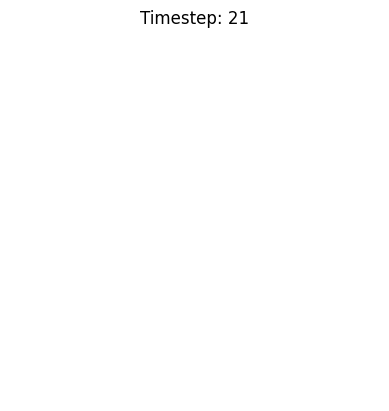

KeyboardInterrupt: 

In [12]:
gui_visualize(agent_dfs, group_dfs, run_number = 1, rep_number= '1', run_length = 200)

In [13]:
visualize_group_grades(group_dfs, run_number=0, rep_number = '1', run_length=200, window=8)

KeyError: '1'

In [ ]:
for agent, agent_run in group_dfs.items():
    print(agent)
    print(agent_run[1].keys())

In [ ]:
for agent, agent_run in agent_dfs.items():
    print(agent)
    print(agent_run[1].keys())

In [ ]:
# identify social loafing


# Visualization techniques to look into
Heatmaps
Want to plot the trjectory of the run, with variance accross runs.

Stable groups?
How do we decide when a group has "filtered out" social loafing behavior?
First, let's track the loafing detection for each group, does it every stabilize?
We can use a line plot to track this. Use the code for tracking grades, and adapt to track number of groups that detected loafing.

In [2]:
def track_loafing(group_dfs, run_number, rep_number, run_length, window = 8):
    interested_groups = {}
    for group, data in group_dfs.items():
        interested_groups[group] = data[run_number][rep_number]
    num_groups = len(interested_groups)

    fig, ax = plt.subplots()

    tracking_loafing_detected = []

    for i in range(run_length):
         for group, data in interested_groups.items():
            if (data['loafing_detected'][i]):
                loafing_detected += 1
        tracking_loafing_detected.append(loafing_detected)
    
    for i in range(run_length - window):
        loafing_detected = 0
        ax.set_title(f"Number of Groups That Detected Loafing. Timestep: {i + 1}")
        ax.set_ylim(0, num_groups)
        x_data = list(range(i, i+window))
        y_data = tracking_loafing_detected[i:i+window]
        ax.plot(x_data, y_data)
        
        plt.pause(0.1)
        display(fig)
        clear_output(wait=True)
        ax.set_xlim(i+1, i + window*2)
    return tracking_loafing_detected

IndentationError: unindent does not match any outer indentation level (<string>, line 15)